[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marekadamczyk44/ml_uwr/blob/main/Assignments/Assignment2.3.ipynb)

# Bonus Lab Assignment 2.3 

**Submission deadline:**
* **lab session in the week 20-24.12.21**

**Points: 6 points**

The assignment is in the form of a Jupyter notebook. We will be using [Google Colab](https://colab.research.google.com) to solve it. Below you will find a "Setup" section. Follow instructions from this paragraph to download the notebook and open it using [Google Colab](https://colab.research.google.com). 

Your goal is to solve problems posted below. Whenever possible, add your solutions to the notebook.

Please email us about any problems with it - we will try to correct them quickly. Also, please do not hesitate to use GitHub’s pull requests to send us corrections!

## Heads Up!

This assignment comes with starter code, but you are not forced to use it, as long as you execute all analysis demanded in the problems.

In [1]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport

In [2]:
# Standard IPython notebook imports
import itertools
import io
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as sopt
import scipy.stats as sstats
import seaborn as sns
import sklearn.ensemble
import sklearn.tree
from sklearn import datasets
from tqdm.auto import tqdm

import httpimport

# In this way we can import functions straight from github
with httpimport.github_repo(
    "janchorowski", "nn_assignments", module="common", branch="nn18"
):
    from common.gradients import check_gradient
    from common.plotting import plot_mat

sns.set_style("whitegrid")

# Problem 1 [1-6p]



Let us focus again on linear regression. Recall the two objective functions with which you can measure the fit of your line to the data. Mean Square Error: $\frac{1}{N}\sum_{i=1}^N (y^{(i)} - x^{(i)}\Theta)^2,$ 
and Mean Absolute Error: $\frac{1}{N}\sum_{i=1}^N \left | y^{(i)} - x^{(i)}\Theta \right|$.

Hence you can write the loss function more general $$\frac{1}{N}\sum_{i=1}^N L\left(y^{(i)} - x^{(i)}\Theta\right),$$ where $L(x) = x^2$ for measuring the error for the mean square criterion, and $L(x) = |x|$ for the mean absolute criterion.

Mean Square error criterion works very well if the errors are distributed according to a Gaussian distribution. However, as pointed out in the lecture, it works very poorly in case of the outliers. On the other hand Mean Absolute Error criterion is note affected for the outliers, however it assumes that the errors are distributed according to the Laplace distribution which is not always the case.
The best of both worlds is obtained with Huber loss, where 
$$
L (a) = \begin{cases}
 \frac{1}{2}{a^2}                   & \text{for } |a| \le \delta, \\
 \delta (|a| - \frac{1}{2}\delta), & \text{otherwise.}
\end{cases}
$$ for some parameter $\delta$.
And this idea can also be implemented via pseudo Huber loss of $\delta\left(\sqrt{\left(\frac{x}{\delta}\right)^2 + 1} - 1\right)$.





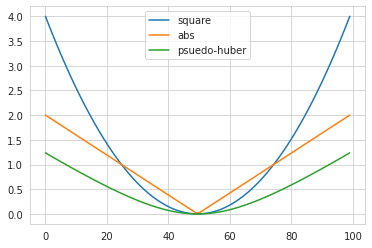

In [3]:
import pandas as pd
import numpy as np

x = np.linspace(-2, 2, 100)
L = pd.DataFrame()
L["square"] = x**2
L["abs"] = abs(x)
L["psuedo-huber"] = np.sqrt(x**2+1)-1 
L.plot()

Hence, it seems like the amount of functions that can be used to model errors in linear regression is very vast, and that's actually the case.

In the paper [General Robust loss function](https://arxiv.org/abs/1701.03077) a function that generalizes all of these functions is presented. 

In [4]:
#filling this cell is part of Task 1

def rho(x, alpha, c): #the general robust loss function
    alpha += 1e-5
    alfabs = abs(alpha - 2)
    return (alfabs/alpha)  *  ((((x/c)**2)/alfabs + 1)**(alpha/2) - 1)

def d_rho(x, alpha, c): #and its derivative
    alpha += 1e-5
    alfabs = abs(alpha - 2)
    return (x/c**2) * (((x/c)**2)/alfabs + 1)**(alpha/2 - 1)



The function $\rho$ is parametrized with $\alpha$ and $c$. Different values of $\alpha$ correspond to different shapes of the function:


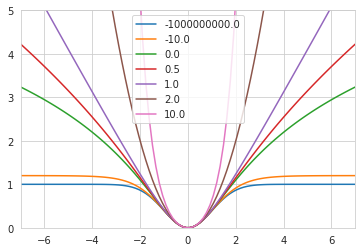

In [5]:
x = np.linspace(-7, 7, 100)
R = pd.DataFrame(index=x)
for alpha in [-1e+9, -10, 0, 0.5, 1., 2., 10.]:
    R[alpha] = rho(x, alpha, c=1.)
R.plot(xlim=(-7,7),ylim=(0,5))

## Task 1 [1p]
Implement the $\rho$ function from the paper, and its derivative.

## Task 2 [1p]

For different values of $alpha$ (and $c=1$) fit $\rho(\cdot,alpha,c)$ into the house dataset

In [6]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/janchorowski/nn_assignments/nn18/assignment3/03-house-prices-outliers.csv",
    index_col=0,
)
data.head()

,rooms,area,price
0,3,66.80,367.801
1,3,55.03,289.458
2,4,70.80,389.000
3,1,29.02,195.695
4,2,45.76,265.754


In [7]:
X = np.stack((np.ones_like(data.area), data.area)).T
Y = np.asarray(data.price)
X, Y

(array([[ 1.  , 66.8 ],
        [ 1.  , 55.03],
        [ 1.  , 70.8 ],
        ...,
        [ 1.  , 46.7 ],
        [ 1.  , 50.41],
        [ 1.  , 48.1 ]]),
 array([367.801, 289.458, 389.   , ..., 266.   , 267.1  , 269.   ]))

In [8]:
def linreg_general_loss(Theta, X, Y, alpha, c):
    #TODO
    def powers_of_X(X, degree):
        powers = np.arange(degree + 1).reshape(1, -1)
        return X ** powers

    def compute_polynomial(X, Theta):
        XP = powers_of_X(X, len(Theta) - 1)
        Y = (XP @ Theta)
        return Y
    
    errors = Y - compute_polynomial(X, Theta)
    loss = sum(rho(errors, alpha, c))
    grad = sum(d_rho(errors, alpha, c).reshape(-1,1) * -Theta)

    return loss, grad.reshape(Theta.shape)


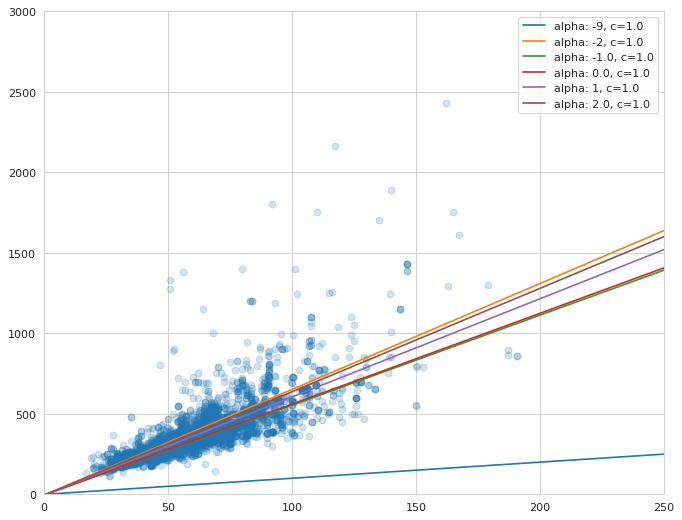

In [9]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=80)

plt.scatter(X[:,1], Y, alpha=0.2)
area = np.linspace(0,400,1000)
Theta0 = np.asarray([-1,1])

for alpha in [-9, -2,-1., 0., 1, 2.]:
    for c in [1.]:
        ThetaOpt, _, dic = sopt.fmin_l_bfgs_b(
            lambda Theta: linreg_general_loss(Theta, X, Y, alpha=alpha+1e-9, c=c), np.array(Theta0)
        )
        price = ThetaOpt[1] * area + ThetaOpt[0]
        plt.plot(area, price, label=f"alpha: {alpha}, c={c}")

plt.xlim(0, 250)  # xlim_area[1])
plt.ylim(0, 3000)
plt.legend()


## Task 3 [1p]

As you can see in the plot above, different $\alpha$'s yield different lines. A natural question pops up: which $\alpha$ is the best?
But what does "best" even mean here? How we can quantitatively compare $\alpha$'s? Measuring the fit to the data of every line with a measure of form $$\frac{1}{N}\sum_{i=1}^N some-measure-function(y^{(i)} - x^{(i)}\Theta)$$
doesn't really make sense now.

However, we can look at it from the point of view of MLE estimators. 

As we have seen in the lecture, mean square error criterion which uses $x \mapsto x^2$ as an error measuring function corresponds to MLE under assumption that the errors are distributed according to a zero-mean normal distribution. In other words when the data $X,y$ we have was really generated by a random process such that $y_i = \Theta\cdot x_i + N(0,\sigma)$ for some $\Theta$ and some $\sigma$. And it happens that the probability density function of a normal distribution $N(0, \sigma)$ is $\frac{1}{\sigma}e^{-\frac{1}{2}\frac{x^2}{\sigma}}$

One can reproduce the proof that minimizing MSE finds MLE for normal distributions to get the proof that if the errors are distributed according to $$\frac{1}{c\cdot Z(\alpha)}e^{-\rho(x, \alpha, c)},$$ 
i.e., data is generated as $y_i = \Theta\cdot x_i + error_i$ with $error_i$ being a random variable whose probability density function is $\frac{1}{c\cdot Z(\alpha)}e^{-\rho(x, \alpha, c)}$. $Z(\alpha)$ here is a normalization constant which makes the density function integrate to $1$, that is, $Z(\alpha) = \int_{-\infty}^\infty e^{-\rho(x, \alpha, c)} \mbox{d}x$.

Reproduce this proof to get 1 point.

$ϵ_i = y_i - Θx_i$

$\rho_i = \rho(\epsilon_i, α, c)$

$$
nll(Θ, α) = -log\prod_{i=1}^N P(y_i|x_i, Θ, α) = -\sum_{i=1}^N log(\frac{e^{-\rho_i}}{cZ(α)}) =\sum_{i=1}^N \rho_i + log(cZ(α))
$$

## Task 4 [1 vs 3p]

So now we have a clear criterion for comparing $alpha$'s. Add $\alpha$ as a parameter to the  training and find $\alpha$ and corresponding $\Theta$ that minimizes the negative log likelihood. Keep $c$ equal to $1$ everywhere, although this also can be tunable in general.

You will get 3 points if you will compute the derivative of $\rho$ over $\alpha$ and use is it in the gradient for fmin_l_bfgs_b

You will get 1 point if you will do a search over space of $alpha$'s, for every $\alpha$ you will use fmin_l_bfgs_b only for $\Theta$ and find the pair $\alpha$, $\Theta$ which maximizes the NLL.

**Note** that $Z(\alpha)$ needs to be computed in the gradient, so you will need to compute the integral $\int_{-\infty}^\infty e^{-\rho(x, \alpha, c)} \mbox{d}x$.

In [10]:
from sympy import *
x = Symbol('x')
a = Symbol('a')
c = 1


alfabs = abs(a - 2)
y = (alfabs/a)  *  ((((x/c)**2)/alfabs + 1)**(a/2) - 1)
diff = y.diff(a)
print('🥲')
diff

🥲


(x**2/Abs(a - 2) + 1)**(a/2)*(-a*x**2*((re(a) - 2)*Derivative(re(a), a) + im(a)*Derivative(im(a), a))*sign(a - 2)/(2*(a - 2)*(x**2/Abs(a - 2) + 1)*Abs(a - 2)**2) + log(x**2/Abs(a - 2) + 1)/2)*Abs(a - 2)/a + ((re(a) - 2)*Derivative(re(a), a) + im(a)*Derivative(im(a), a))*((x**2/Abs(a - 2) + 1)**(a/2) - 1)*sign(a - 2)/(a*(a - 2)) - ((x**2/Abs(a - 2) + 1)**(a/2) - 1)*Abs(a - 2)/a**2

In [11]:
# szczęśliwie można to rozbić na przypadki 😇
alfabs = Symbol('|a-2|')
y = (alfabs/a)  *  ((((x/c)**2)/alfabs + 1)**(a/2) - 1)

diff_positive = y.subs(alfabs, (a - 2)).diff(a)
diff_negative = y.subs(alfabs, -(a - 2)).diff(a)
y

|a-2|*((x**2/|a-2| + 1)**(a/2) - 1)/a

In [12]:
diff_positive

(a - 2)*(x**2/(a - 2) + 1)**(a/2)*(-a*x**2/(2*(a - 2)**2*(x**2/(a - 2) + 1)) + log(x**2/(a - 2) + 1)/2)/a + ((x**2/(a - 2) + 1)**(a/2) - 1)/a - (a - 2)*((x**2/(a - 2) + 1)**(a/2) - 1)/a**2

In [13]:
diff_negative

(2 - a)*(x**2/(2 - a) + 1)**(a/2)*(a*x**2/(2*(2 - a)**2*(x**2/(2 - a) + 1)) + log(x**2/(2 - a) + 1)/2)/a - ((x**2/(2 - a) + 1)**(a/2) - 1)/a - (2 - a)*((x**2/(2 - a) + 1)**(a/2) - 1)/a**2

In [14]:
def da_rho(x_arg, a_arg):
    substitutions = [(a, a_arg), (x, x_arg)]
    res =  diff_positive.subs(substitutions) if a_arg > 2 else diff_negative.subs(substitutions)
    return res.evalf()

In [15]:
from scipy.integrate import quad
def integrand(x, alpha):
    return np.exp(-rho(x, alpha, 1))

def Z(alpha):
    return quad(integrand, -np.inf, np.inf, args=(alpha))[0]


def general_loss(args, X, Y):
    def powers_of_X(X, degree):
        powers = np.arange(degree + 1).reshape(1, -1)
        return X ** powers

    def compute_polynomial(X, Theta):
        XP = powers_of_X(X, len(Theta) - 1)
        Y = (XP @ Theta)
        return Y

    # unpack the goods
    *Theta, alpha = args
    Theta = np.array(Theta)
    c = 1
    
    
    errors = Y - compute_polynomial(X, Theta)
    zet = Z(alpha)

    loss = sum(rho(errors, alpha, c)) + c*zet*len(errors)
    grad = sum(d_rho(errors, alpha, c).reshape(-1,1) * -Theta)
    ag = sum(da_rho(e, alpha) + np.exp(-rho(e, alpha, 1))/(c - zet) for e in errors) # slowwww

    print(loss, np.concatenate((grad.reshape(Theta.shape), np.array([ag], dtype=grad.dtype))))

    return loss, np.concatenate((grad.reshape(Theta.shape), np.array([ag], dtype=grad.dtype)))

In [16]:
general_loss([1,-1,1], X, Y)

2584054.0831629313 [-5.92030205e+03  5.92030205e+03  1.21730546e+07]


(2584054.0831629313,
 array([-5.92030205e+03,  5.92030205e+03,  1.21730546e+07]))

In [ ]:
# 🚫 Uwaga! Długie obliczenia (sympy nie obsługuje rachunku macierzowego, przynajmniej nie w jakiś prosty sposób)
# Z(ɑ) jest niezdefiniowana dla ɑ < 0 nie wiedziałem jak to obejść, więc przestrzeń przeszukiwań jest ograniczona do dodatnich ɑ :(
# Proponowana alfa to 0.0001, czyli właściwie 0 (z przyczyn numerycznych)

from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=80)

plt.scatter(X[:,1], Y, alpha=0.2)
area = np.linspace(0,400,1000)

ArgsOpt, _, dic = sopt.fmin_l_bfgs_b(
    lambda Args: general_loss(Args, X, Y), np.array([-1.,1.,1.]),
    bounds = [(-np.inf, np.inf), (-np.inf, np.inf), (0.0001, np.inf)]
)

*Theta, Alpha = ArgsOpt
print(Theta, Alpha)

price = Theta[1] * area + Theta[0]
plt.plot(area, price, label=f"alpha: {Alpha}, c={c}")

plt.xlim(0, 250)  # xlim_area[1])
plt.ylim(0, 3000)
plt.legend()

1890450.5543809864 [ 5.92025966e+03 -5.92025966e+03  8.40871298e+06]
1644374.0187193835 [  10100.43690345  -10100.43690345 7135694.80815447]
673828.0746896613 [  25073.80031139  -25073.80031139 2630939.98773787]
3382381.380216112 [  -92076.82534019    92076.82534019 16761861.12844637]
535878.9319313696 [  24822.923039    -24822.923039   2091630.61564424]
531689.3997906011 [  24794.91054295  -24794.91054295 2075997.20480203]
1559175.6181766 [ -59948.09088748   59948.09088748 6698129.66912717]
464771.7561305096 [  23751.81296551  -23751.81296551 1835108.87946933]
462500.58575492114 [  23610.11273818  -23610.11273818 1827313.50088889]
735517.3872812481 [ -40036.63124423   40036.63124423 2849553.79068322]
419959.71312934137 [  19310.24575884  -19310.24575884 1681631.78036286]
418654.4472433198 [  19072.68721645  -19072.68721645 1677174.14598116]
430821.79074252886 [ -21695.32200012   21695.32200012 1689798.49173055]
376350.1904417697 [   5368.47458309   -5368.47458309 1511902.19947616]
158

In [ ]:
from matplotlib.pyplot import figure

def powers_of_X(X, degree):
    powers = np.arange(degree + 1).reshape(1, -1)
    return X ** powers

def compute_polynomial(X, Theta):
    XP = powers_of_X(X, len(Theta) - 1)
    Y = (XP @ Theta)
    return Y

def criterion(alpha, c=1):
    errors = Y-compute_polynomial(X, ThetaOpt)
    C = c*Z(alpha)*len(errors)
    print(C)
    return sum(rho(errors, alpha, c)) + np.log(C)

    


figure(figsize=(10, 8), dpi=80)
plt.scatter(X[:,1], Y, alpha=0.2)
area = np.linspace(0,400,1000)
Theta0 = np.asarray([-1,1])

for alpha in [0., 0.3, 1, 2., 3., 10.]:
    for c in [1.]:
        ThetaOpt, _, dic = sopt.fmin_l_bfgs_b(
            lambda Theta: linreg_general_loss(Theta, X, Y, alpha=alpha+1e-9, c=c), np.array(Theta0)
        )
        price = ThetaOpt[1] * area + ThetaOpt[0]
        plt.plot(area, price, label=f"alpha: {alpha}, ρ={criterion(alpha)}")

plt.xlim(0, 250)
plt.ylim(0, 3000)
plt.legend()

Wygląda na to, że alfa = 0 jest najlepsza 